#  Displacement-based Earthquake Loss Assessment - Silva et al. 2013

In this fragility method, thousands of synthetic buildings can be produced considering probabilistic distributions for the variability in the geometrical and material properties. The nonlinear capacity can be estimated using the displacement-based earthquake loss assessment theory. The structures are subject to a large set of ground motion records and the performance is calculated. Global limit states are used to estimate the distribution of buildings in each damage state for different levels of ground motion, and a regression algorithm is applied to derive fragility curves for each limit state.

In the following figure, a fragility model developed using this method is presented: 
<img src="../../../../../figures/fragility_example.png" width="400" align="middle">

**Note**: To run the code in a cell:

1. Click on the cell to select it.
2. Press `SHIFT+ENTER` on your keyboard or press the play button (<button class='fa fa-play icon-play btn btn-xs btn-default'></button>) in the toolbar above.

In [24]:
import DBELA
from rmtk.vulnerability.common import utils
%matplotlib inline 

---
###Load capacity curves

In order to use this methodology, it is necessary to provide one (or a group) of capacity curves, defined according to the format described in the [RMTK manual](../../../../../rmtk-docs.pdf).

Please provide the location of the file containing the capacity curves using the parameter `capacity_curves_file`.

In [25]:
capacity_curves_file = "../../../../../../rmtk_data/capacity_curves_dbela.csv"

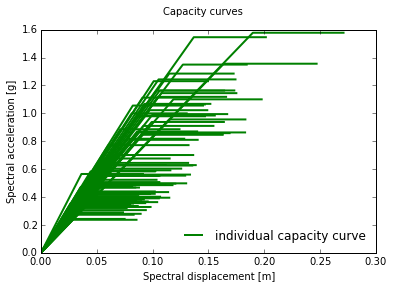

In [26]:
capacity_curves = utils.read_capacity_curves(capacity_curves_file)
utils.plot_capacity_curves(capacity_curves)

### Load ground motion records

Please indicate the path to the folder containing the ground motion records to be used in the analysis through the parameter `gmrs_folder`.

**Note**: Each accelerogram needs to be in a separate CSV file as described in the [RMTK manual](../../../../../rmtk-docs.pdf).

The parameters `minT` and `maxT` are used to define the period bounds when plotting the spectra for the provided ground motion fields.

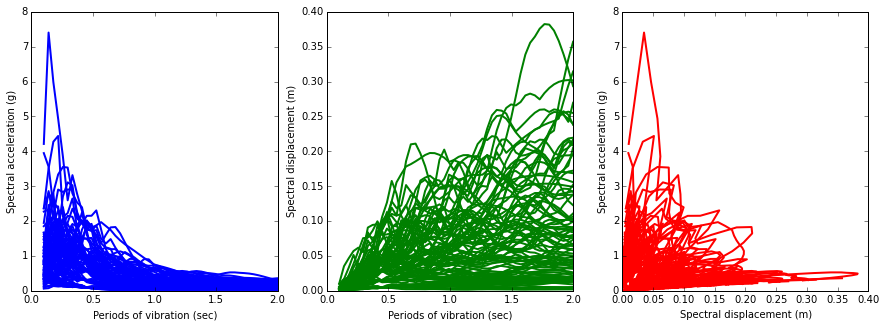

In [27]:
gmrs_folder = "../../../../../../rmtk_data/accelerograms"
gmrs = utils.read_gmrs(gmrs_folder)
minT = 0.1
maxT = 2.0
utils.plot_response_spectra(gmrs, minT, maxT)

###Load damage state thresholds

Please provide the path to your damage model file using the parameter `damage_model_file` in the cell below.

In [28]:
damage_model_file = "../../../../../../rmtk_data/damage_model_dbela_low_code.csv"

In [29]:
damage_model = utils.read_damage_model(damage_model_file)
print damage_model

{'damage_states': ['LS1', 'LS2', 'LS3'], 'cov': [[0.0], [0.45, 0.45], [0.45, 0.45]], 'type_criteria': 'strain dependent', 'type_damage_state': ['Sdy', 'strain', 'strain'], 'distribution': ['lognormal', 'lognormal', 'lognormal'], 'mean': [[], [0.0045, 0.0125], [0.0075, 0.0225]]}


###Obtain the damage probability matrix

The parameter `structure_type` needs to be defined in the cell below in order to calculate the damage probability matrix. The valid options are "bare frame" and "infilled frame".

In [30]:
structure_type = "bare frame"

In [ ]:
PDM = DBELA.calculate_fragility(capacity_curves, gmrs, damage_model, structure_type)

### Fit lognormal CDF fragility curves
The following parameters need to be defined in the cell below in order to fit lognormal CDF fragility curves to the damage probability matrix obtained above:
1. `IMT`: This parameter specifies the intensity measure type to be used. Currently supported options are "PGA", "PGV" and "Sa".
2. `period`: This parameter defines the time period of the fundamental mode of vibration of the structure.
3. `damping_ratio`: This parameter defines the damping ratio for the structure
4. `regression_method`: This parameter defines the regression method to be used for estimating the parameters of the fragility functions. The valid options are "least squares" and "max likelihood".

In [32]:
IMT = "Sa"
period = 2.0
damping_ratio = 0.05
regression_method = "least squares"

In [33]:
fragility_model = utils.calculate_mean_fragility(gmrs, PDM, period, damping_ratio, 
                                                 IMT, damage_model, regression_method)

### Plot fragility functions
The following parameters need to be defined in the cell below in order to plot the lognormal CDF fragility curves obtained above:
* `minIML` and `maxIML`: These parameters define the limits of the intensity measure level for plotting the functions

In [34]:
minIML, maxIML = 0.01, 2.00

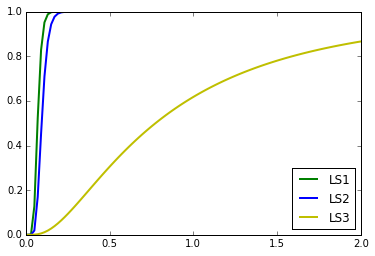

In [35]:
utils.plot_fragility_model(fragility_model, minIML, maxIML)

### Save fragility functions
The derived parametric fragility functions can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
2. `minIML` and `maxIML`: These parameters define the bounds of applicability of the functions.
3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [36]:
taxonomy = "RC"
minIML, maxIML = 0.01, 2.00
output_type = "nrml"

In [37]:
utils.save_mean_fragility(taxonomy, fragility_model, minIML, maxIML, output_type)

### Obtain vulnerability function
A vulnerability model can be derived by combining the set of fragility functions obtained above with a consequence model. In this process, the fractions of buildings in each damage state are multiplied by the associated damage ratio from the consequence model, in order to obtain a distribution of loss ratio for each intensity measure level. 

The following parameters need to be defined in the cell below in order to calculate vulnerability functions using the above derived fragility functions:
1. `cons_model_file`: This parameter specifies the path of the consequence model file.
2. `imls`: This parameter specifies a list of intensity measure levels in increasing order at which the distribution of loss ratios are required to be calculated.
3. `distribution_type`: This parameter specifies the type of distribution to be used for calculating the vulnerability function. The distribution types currently supported are "lognormal", "beta", and "PMF".

In [56]:
cons_model_file = "../../../../../../rmtk_data/cons_model_dbela.csv"
imls = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9, 1.0]
distribution_type = "lognormal"

In [60]:
cons_model = utils.read_consequence_model(cons_model_file)
vulnerability_model = utils.convert_fragility_vulnerability(fragility_model, cons_model, 
                                                            imls, distribution_type)

### Save vulnerability function
The derived parametric or nonparametric vulnerability function can be saved to a file in either CSV format or in the NRML format that is used by all OpenQuake input models. The following parameters need to be defined in the cell below in order to save the lognormal CDF fragility curves obtained above:
1. `taxonomy`: This parameter specifies a taxonomy string for the the fragility functions.
3. `output_type`: This parameter specifies the file format to be used for saving the functions. Currently, the formats supported are "csv" and "nrml".

In [61]:
taxonomy = "RC"
output_type = "nrml"

In [ ]:
utils.save_vulnerability(taxonomy, vulnerability_model, output_type)